## Implementation and Notes for Tutorial Article by Daniel Nouri
- [Using convolutional neural nets to detect facial keypoints tutorial by Daniel Nouri](http://danielnouri.org/notes/2014/12/17/using-convolutional-neural-nets-to-detect-facial-keypoints-tutorial/)
- [Kaggle forum thread](https://www.kaggle.com/c/facial-keypoints-detection/details/deep-learning-tutorial)
- more about lasagne and nolearn
    - [Tutorial: Training convolutional neural networks with nolearn](http://nbviewer.ipython.org/github/dnouri/nolearn/blob/master/docs/notebooks/CNN_tutorial.ipynb)
    - [Kaggle: Otto Group Product Classification Challenge using nolearn/lasagne](https://github.com/ottogroup/kaggle/blob/master/Otto_Group_Competition.ipynb)
    - [mnist_conv_autoencode.ipynb](https://github.com/mikesj-public/convolutional_autoencoder/blob/master/mnist_conv_autoencode.ipynb)

*** Use ~~keras~~ Lasagne and nolearn wrapper. Note that lasage needs latest development version of theano***
```sh
[sudo] git pip install git+https://github.com/Theano/Theano.git@15c90dd3#egg=Theano==0.8.git
```

In [1]:
!cat /home/dola/.theanorc

[global]
floatX = float32
device = gpu0
#device = cpu

[nvcc]
fastmath = True

In [2]:
!head -n 1 ../data/kaggle-facial-keypoints/training.csv

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle

In [4]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from sklearn.utils import shuffle

In [5]:
from lasagne import layers, updates
from nolearn.lasagne import NeuralNet ## nolearn wrapper for lasagne, need to install from git to support new lasagne

Using gpu device 0: Quadro K2000 (CNMeM is disabled)


In [3]:
from keras.models import Sequential
from keras.layers.core import Dense


In [6]:
## load data
def load_data(data_path):
    data = pd.read_csv(data_path)
    data["Image"] = data.Image.apply(lambda s: np.fromstring(s, sep = " "))
    return data

train_data = load_data("../data/kaggle-facial-keypoints/training.csv")
test_data = load_data("../data/kaggle-facial-keypoints/test.csv")
print train_data.shape, test_data.shape

(7049, 31) (1783, 2)


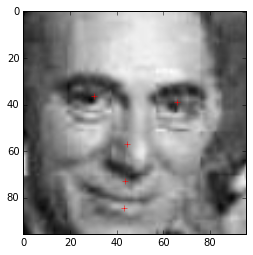

In [7]:
## show an example
plt.imshow(train_data["Image"].iloc[-1].reshape(96, 96), cmap = plt.cm.gray)
plt.autoscale(False)
for p in [("left_eye_center_x","left_eye_center_y"), ("right_eye_center_x","right_eye_center_y")
         , ("nose_tip_x","nose_tip_y"), ("mouth_center_top_lip_x","mouth_center_top_lip_y"),
         ("mouth_center_bottom_lip_x","mouth_center_bottom_lip_y")]:
    x, y = train_data.ix[0, list(p)]
    plt.plot(x, y, "r+")

In [8]:
## prepare train and test data
## take images with all 30 targest, 
## normalize pixels to [0, 1], output (xs, ys) to [-1, 1]
X = np.vstack(train_data.dropna()["Image"]).astype(np.float32)
X = X / 255.
y = train_data.dropna()[[c for c in train_data.columns if c != "Image"]].get_values().astype(np.float32)
y = (y - 48.) / 48. # originally 96 x 96
## shuttle the data
X, y = shuffle(X, y, random_state = 0)
XX = X.reshape((-1, 1, 96, 96))
## split train and validation data

print X.shape, y.shape, XX.shape
print X.dtype, y.dtype
print X.min(), X.max(), y.min(), y.max()

(2140, 9216) (2140, 30) (2140, 1, 96, 96)
float32 float32
0.0 1.0 -0.920287 0.99602


### Trying MLP

mlp takes flatten image vectors

In [9]:
## benchmark MLP with 1 hidden layer
## using nolearn wrapper - sklearn style interface - it follows an interface to sklearn.pipeline
net1 = NeuralNet(
    ## three layers
    layers = [("input", layers.InputLayer)
             , ("hidden", layers.DenseLayer)
             , ("output", layers.DenseLayer)]
    ## layer parameters - see lasagne.layers.XXX for parameter details
    , input_shape = (None, 9216) # batch size not fixed, input dim is 9216
    , hidden_num_units = 100
    , output_nonlinearity = None
    , output_num_units = 30
    
    ## optimization - update parameters,
    , update = updates.nesterov_momentum ## applicable to a wide range of problems
    , update_learning_rate = 0.01 # 0.01 and 0.9, kinda like defacto
    , update_momentum = 0.9
    
    ## problem and objective seeting
    , regression = True
    , max_epochs = 400
    , verbose = 1
)
%time net1.fit(X, y)

# Neural Network with 924730 learnable parameters

## Layer information

  #  name      size
---  ------  ------
  0  input     9216
  1  hidden     100
  2  output      30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.13122       0.04306      3.04714  0.12s
      2       0.04364       0.02832      1.54096  0.12s
      3       0.02091       0.01716      1.21869  0.11s
      4       0.01487       0.01431      1.03857  0.10s
      5       0.01296       0.01310      0.98889  0.12s
      6       0.01210       0.01239      0.97633  0.12s
      7       0.01150       0.01186      0.96925  0.10s
      8       0.01102       0.01144      0.96330  0.11s
      9       0.01063       0.01108      0.95965  0.11s
     10       0.01030       0.01076      0.95718  0.09s
     11       0.01000       0.01049      0.95361  0.09s
     12       0.00974       0.01025      0.95040  0.10s
     13       0.00951       0.01003      0.9

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a190>,
     custom_score=None, hidden_num_units=100, input_shape=(None, 9216),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('hidden', <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7fa33a106d70>,
     objective_loss_function=<function squared_error at 0x7fa33a186050>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7fa32e0ae710>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0x7fa32e0ae908>],
     output_nonlinearity=None, output_num_units=30, regression=True,
     train_split=<nolearn.lasagne.base.TrainSplit objec

(0.001, 0.01)

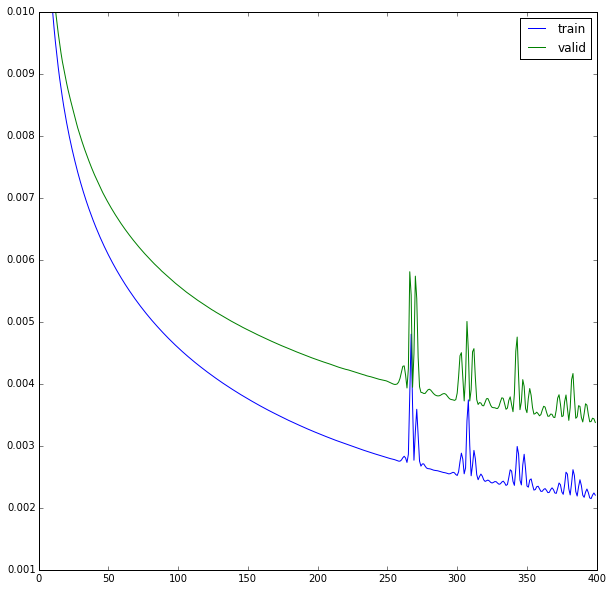

In [10]:
## the most important thing is to get as close as possible to data and model
## e.g., see the train and validation performance
## doesnt look like an overfit because valid is still decreasing/flattening out
## however there is a increasing gap between train and valid error
net1_train_errors = np.array([t["train_loss"] for t in net1.train_history_])
net1_valid_errors = np.array([t["valid_loss"] for t in net1.train_history_])
epochs = np.arange(0, net1_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net1_train_errors, "b-", label = "train")
plt.plot(epochs, net1_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

NameError: name 'net1' is not defined

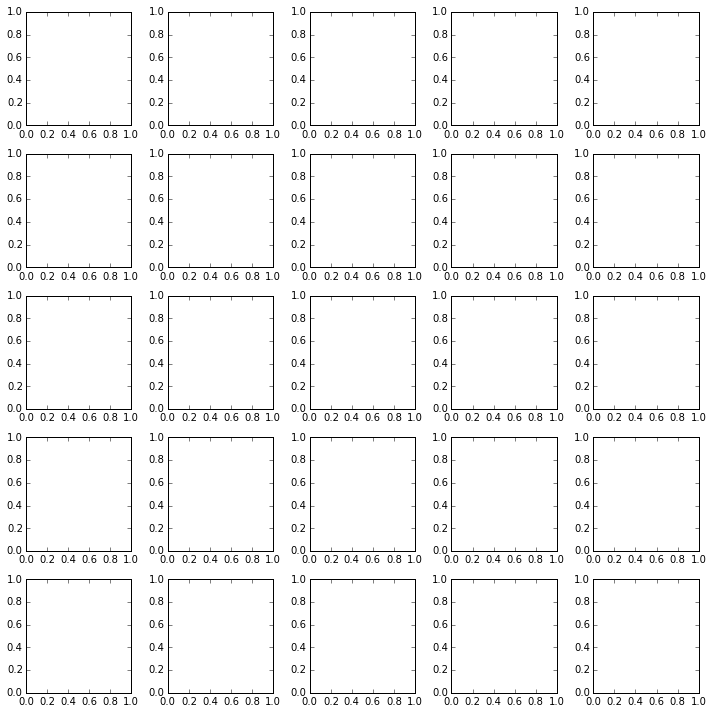

In [9]:
## how good or bad it applies to test data
def plot_face(img, ax):
    ax.imshow(img.reshape(96, 96), cmap = plt.cm.gray)
def plot_features(pts, ax):
    ax.autoscale(False)
    for pt in pts:
        x, y = pt
        ax.plot(x, y, "r+")
        
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net1.predict([img/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

### Trying CNN

cnn takes (nchannel, width, height) images

In [12]:
## layer pattern is (conv, pool+)+
## number of filters are doubled each layer why????

net2 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32, conv1_filter_size = (2, 2) # 32 x 95 x 95
    , pool1_pool_size = (2, 2) # 32 x 47 x 47
    , conv2_num_filters = 64, conv2_filter_size = (2, 2) # 64 x 46 x 46
    , pool2_pool_size = (2, 2) # 64
    , conv3_num_filters = 128, conv3_filter_size = (2, 2)
    , pool3_pool_size = (2, 2) 
    , hidden4_num_units = 500
    , hidden5_num_units = 500
    , output_num_units = 30, output_nonlinearity = None
    
    ## learning algorithm
    , update = updates.nesterov_momentum
    , update_learning_rate = 0.01 ## deafults are good start
    , update_momentum = 0.9
    
    ## objective and problem definition
    , regression = True
    , max_epochs = 400
    , verbose = 1
)

XX = X.reshape((-1, 1, 96, 96))
%time net2.fit(XX, y)

# Neural Network with 8051342 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x95x95
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.09496       0.02015      4.71339  5.02s
      2       0.01398       0.00914      1.53004  5.25s
      3       0.00846       0.00791      1.06909  5.07s
      4       0.00732       0.00732      1.00038  4.93s
      5       0.00696       0.00699      0.99629  4.99s
      6       0.00669       0.00673      0.99475  4.98s
      7       0.00647       0.00650      0.99588  4.93s
      8       0.00628       0.00630      0.99676  4.97s
      9       0.00612       0.00613      0.99748  5.10s
     10       0.00597       0.00598      0.99807  5.0

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a210>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a190>,
     conv1_filter_size=(2, 2), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=400, more_params={},
     objective=<function objective at 0x7fa33a106d70>,
     objective

In [23]:
cPickle.dump(net2, open("../data/kaggle-facial-keypoints/models/lasagne/net2.pkl", "w"), -1)

(0.001, 0.01)

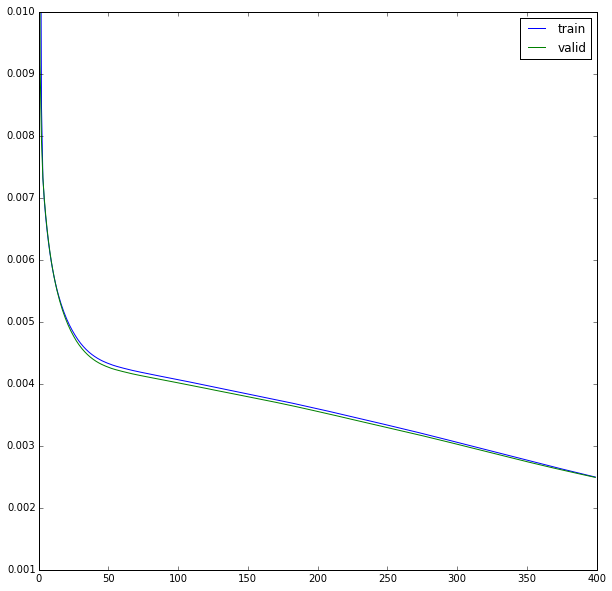

In [20]:
## obviously it is not fully trained with 400 epochs, because both train and valid 
## are tightly decreasing.
## but I stop here because it takes long time to finish the full training in the demostration
net2_train_errors = np.array([t["train_loss"] for t in net2.train_history_])
net2_valid_errors = np.array([t["valid_loss"] for t in net2.train_history_])
epochs = np.arange(0, net2_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net2_train_errors, "b-", label = "train")
plt.plot(epochs, net2_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

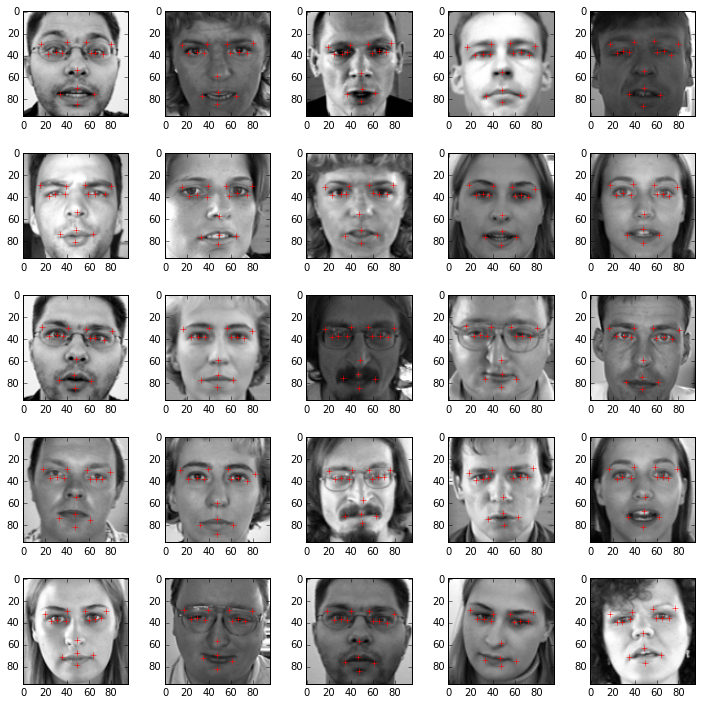

In [21]:
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net2.predict([img.reshape((1, 96, 96))/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

### Augment the data on the fly
- idea: flip images along vertical axis (mirror) to get double size of training
- do it on the fly via BatchIterator to avoid large memory usage
- need to change both image and target when mirroring the image (x -> 1-x, left -> right)

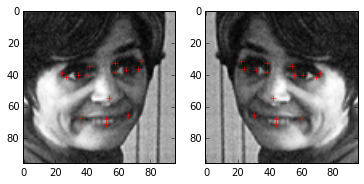

In [10]:
## example of mirror the image
def mirror_vertical(v):
    pts = np.array(zip(v[::2], v[1::2]))
    ## x becomes 0 - x 
    pts[:, 0] = -1. * pts[:, 0]
    ## change left to right
    swap = [(0, 1), (2, 4), (3, 5), (6, 8), (7, 9), (11, 12)]
    for left, right in swap:
        #a = pts[left, :].copy()
        #pts[left, :] = pts[right, :]
        #pts[right,:] = a
        pts[[left, right], :] = pts[[right, left], :]
    return pts.ravel()

i = 0
img = XX[i].reshape((96, 96))
mimg = img[:, ::-1]
pts = np.array(zip(y[i, ::2], y[i, 1::2])) * 48. + 48.
mv = mirror_vertical(y[i,:])
mpts = np.array(zip(mv[::2], mv[1::2])) * 48. + 48.

fig, axes = plt.subplots(1, 2, figsize = (6, 3))
plot_face(img, ax=axes[0])
plot_features(pts, ax = axes[0])

plot_face(mimg, ax = axes[1])
plot_features(mpts, ax = axes[1])

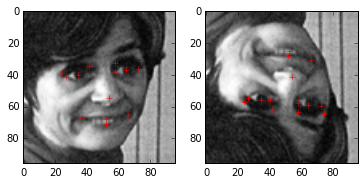

In [11]:
## example of mirror the image
def mirror_horizontal(v):
    pts = np.array(zip(v[::2], v[1::2]))
    ## x becomes 0 - x 
    pts[:, 1] = -1. * pts[:, 1]
    ## change left to right
    return pts.ravel()

i = 0
img = XX[i].reshape((96, 96))
mimg = img[::-1, :]
pts = np.array(zip(y[i, ::2], y[i, 1::2])) * 48. + 48.
mv = mirror_horizontal(y[i,:])
mpts = np.array(zip(mv[::2], mv[1::2])) * 48. + 48.

fig, axes = plt.subplots(1, 2, figsize = (6, 3))
plot_face(img, ax=axes[0])
plot_features(pts, ax = axes[0])

plot_face(mimg, ax = axes[1])
plot_features(mpts, ax = axes[1])

In [104]:
## use BatchIterator to do on-the-fly image augumentation
from nolearn.lasagne.base import BatchIterator

class FlipBatchIterator(BatchIterator):
    def transform(self, Xb, yb):
        """
        Xb, yb are batch of inputs and outputs
        Flip 1/3 of images leftside right, Flip 1/3 of images upside down
        """
        Xb, yb = super(FlipBatchIterator, self).transform(Xb, yb)
        batch_size = Xb.shape[0]
        ## vertical flip
        selected = np.random.choice(batch_size, batch_size/2, replace = False)
        N = selected.shape[0]
        Xb[selected[:N/2], ...] = Xb[selected[:N/2], :, :, ::-1]
        yb[selected[:N/2], ...] = np.array(map(mirror_vertical, yb[selected[:N/2], ...]))
        ## horizontal flip
        Xb[selected[N/2:], ...] = Xb[selected[N/2:], :, ::-1, :]
        yb[selected[N/2:], ...] = np.array(map(mirror_horizontal, yb[selected[N/2:], ...]))
        return Xb, yb

In [96]:
## network 3 is exactly the same as network 2, except the new data augument BatchIterator


net3 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32, conv1_filter_size = (2, 2) # 32 x 95 x 95
    , pool1_pool_size = (2, 2) # 32 x 47 x 47
    , conv2_num_filters = 64, conv2_filter_size = (2, 2) # 64 x 46 x 46
    , pool2_pool_size = (2, 2) # 64
    , conv3_num_filters = 128, conv3_filter_size = (2, 2)
    , pool3_pool_size = (2, 2) 
    , hidden4_num_units = 500
    , hidden5_num_units = 500
    , output_num_units = 30, output_nonlinearity = None
    
    ## learning algorithm
    , update = updates.nesterov_momentum
    , update_learning_rate = 0.01 ## deafults are good start
    , update_momentum = 0.9
    
    ## objective and problem definition
    , regression = True
    , max_epochs = 800
    , verbose = 1
    
    ## data arugment batch iterator - by fliping images vertically and horizontally
    , batch_iterator_train=FlipBatchIterator(batch_size = 128)
)


%time net3.fit(XX, y)

# Neural Network with 8051342 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x95x95
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  -----
      1       0.11919       0.04628      2.57559  5.02s
      2       0.08305       0.05009      1.65797  5.01s
      3       0.08145       0.06270      1.29900  4.97s
      4       0.08142       0.07007      1.16207  4.97s
      5       0.08033       0.07750      1.03655  4.98s
      6       0.07798       0.07126      1.09430  4.99s
      7       0.07544       0.06839      1.10303  5.02s
      8       0.07206       0.07020      1.02646  4.99s
      9       0.06745       0.07248      0.93051  5.00s
     10       0.06153       0.06485      0.94877  4.9

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7fa33a10a210>,
     batch_iterator_train=<__main__.FlipBatchIterator object at 0x7fa2bd043510>,
     conv1_filter_size=(2, 2), conv1_num_filters=32,
     conv2_filter_size=(2, 2), conv2_num_filters=64,
     conv3_filter_size=(2, 2), conv3_num_filters=128, custom_score=None,
     hidden4_num_units=500, hidden5_num_units=500,
     input_shape=(None, 1, 96, 96),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool1', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('pool2', <class 'lasagne.layers.pool.MaxPool2DLayer'>), ('conv3', <class..., <class 'lasagne.layers.dense.DenseLayer'>), ('output', <class 'lasagne.layers.dense.DenseLayer'>)],
     loss=None, max_epochs=800, more_params={},
     objective=<function objective at 0x7fa33a106d70>,
     objective_loss_fu

In [105]:

cPickle.dump(net3, open("../data/kaggle-facial-keypoints/models/lasagne/net3.pkl", "wb"), -1)

(0.001, 0.01)

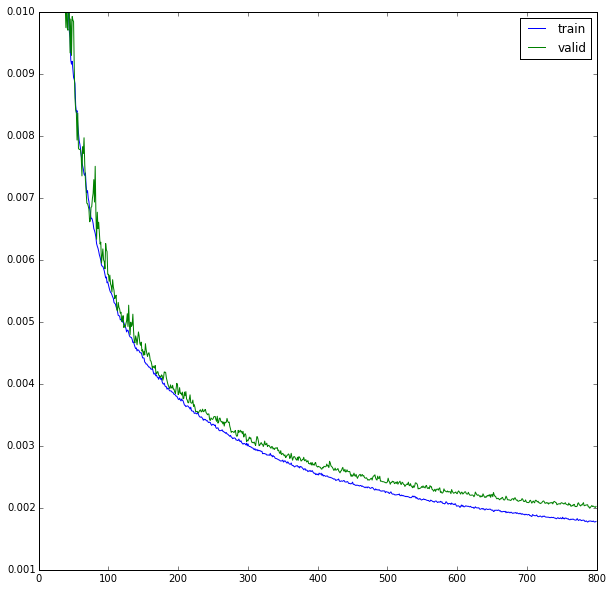

In [97]:
net3_train_errors = np.array([t["train_loss"] for t in net3.train_history_])
net3_valid_errors = np.array([t["valid_loss"] for t in net3.train_history_])
epochs = np.arange(0, net3_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net3_train_errors, "b-", label = "train")
plt.plot(epochs, net3_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

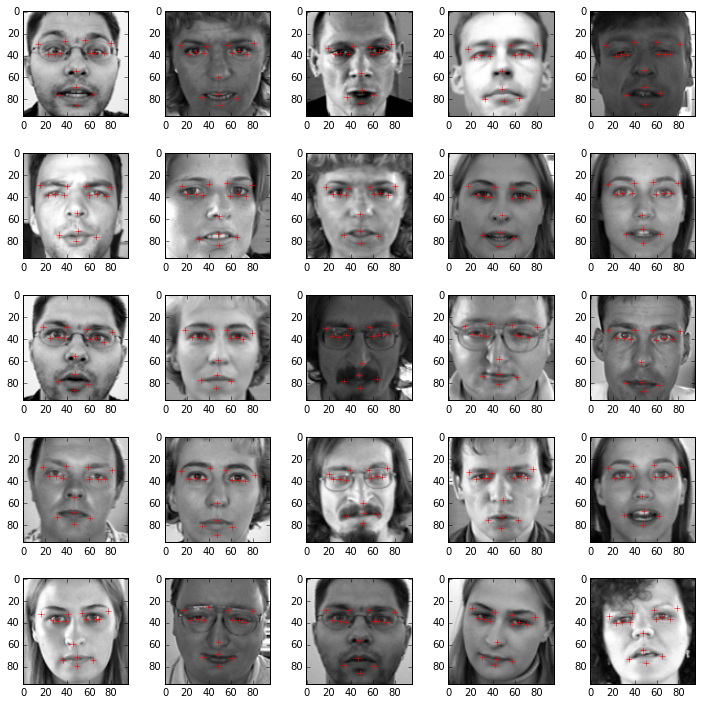

In [98]:
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net3.predict([img.reshape((1, 96, 96))/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)

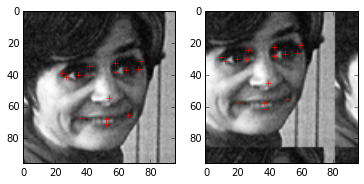

In [20]:
## jitter effect
## example of mirror the image

def jitter(v ,ox, oy):
    vv = v.copy()
    vv[::2] += ox
    vv[1::2] += oy
    return vv

j = 15
ox, oy = np.random.randint(-j, j+1, 2)
i = 0
img = XX[i].reshape((96, 96))
mimg = np.roll(np.roll(XX[i, :, :, :], ox, -1), oy, -2)
pts = np.array(zip(y[i, ::2], y[i, 1::2])) * 48. + 48.
mv = jitter(y[i,:], ox/48., oy/48. )
mpts = np.array(zip(mv[::2], mv[1::2])) * 48. + 48.

fig, axes = plt.subplots(1, 2, figsize = (6, 3))
plot_face(img, ax=axes[0])
plot_features(pts, ax = axes[0])

plot_face(mimg, ax = axes[1])
plot_features(mpts, ax = axes[1])

In [ ]:
## use BatchIterator to do on-the-fly image augumentation
# boht filpping and jittering

## Jittering causes diverge!!!!

from nolearn.lasagne.base import BatchIterator


class FlipAndOffsetBatchIterator(BatchIterator):
    def transform(self, Xb, yb):
        """
        Xb, yb are batch of inputs and outputs
        Flip 1/3 of images leftside right, Flip 1/3 of images upside down
        """
        Xb, yb = super(FlipAndOffsetBatchIterator, self).transform(Xb, yb)
        batch_size = Xb.shape[0]
        ## vertical flip
        selected = np.random.choice(batch_size, batch_size/2, replace = False)
        N = selected.shape[0]
        Xb[selected[:N/2], ...] = Xb[selected[:N/2], :, :, ::-1]
        yb[selected[:N/2], ...] = np.array(map(mirror_vertical, yb[selected[:N/2], ...]))
        ## jitter offset
        j = 15
        ox, oy = np.random.randint(-j, j+1, 2)
        Xb[selected[N/2:N*6/10], ...] = np.roll(np.roll(Xb[selected[N/2:N*6/10], :, :, :], ox, -1), oy, -2, )
        yb[selected[N/2:N*6/10], ...] = np.array(map(lambda v: jitter(v, ox/48., oy/48. ), yb[selected[N/2:N*6/10], ...]))
        return Xb, yb
    
net5 = NeuralNet(
    ## layers
    layers = [
        ("input", layers.InputLayer)
        , ("conv1", layers.Conv2DLayer)
        , ("pool1", layers.MaxPool2DLayer)
        , ("conv2", layers.Conv2DLayer)
        , ("pool2", layers.MaxPool2DLayer)
        , ("conv3", layers.Conv2DLayer)
        , ("pool3", layers.MaxPool2DLayer)
        , ("hidden4", layers.DenseLayer)
        , ("hidden5", layers.DenseLayer)
        , ("output", layers.DenseLayer)
    ]
    ## layer parameters
    , input_shape = (None, 1, 96, 96) # flexible batch size
    , conv1_num_filters = 32, conv1_filter_size = (2, 2) # 32 x 95 x 95
    , pool1_pool_size = (2, 2) # 32 x 47 x 47
    , conv2_num_filters = 64, conv2_filter_size = (2, 2) # 64 x 46 x 46
    , pool2_pool_size = (2, 2) # 64
    , conv3_num_filters = 128, conv3_filter_size = (2, 2)
    , pool3_pool_size = (2, 2) 
    , hidden4_num_units = 500
    , hidden5_num_units = 500
    , output_num_units = 30, output_nonlinearity = None
    
    ## learning algorithm
    , update = updates.nesterov_momentum
    , update_learning_rate = 0.0001 ## deafults are good start
    , update_momentum = 0.6
    
    ## objective and problem definition
    , regression = True
    , max_epochs = 800
    , verbose = 1
    
    ## data arugment batch iterator - by fliping images vertically and horizontally
    , batch_iterator_train=FlipAndOffsetBatchIterator(batch_size = 64)
)
#net3 = cPickle.load(open("../data/kaggle-facial-keypoints/models/lasagne/net3.pkl"))
#net5.load_params_from(net3.get_all_params_values())

%time net5.fit(XX, y)

# Neural Network with 8051342 learnable parameters

## Layer information

  #  name     size
---  -------  ---------
  0  input    1x96x96
  1  conv1    32x95x95
  2  pool1    32x47x47
  3  conv2    64x46x46
  4  pool2    64x23x23
  5  conv3    128x22x22
  6  pool3    128x11x11
  7  hidden4  500
  8  hidden5  500
  9  output   30



(0.001, 0.01)

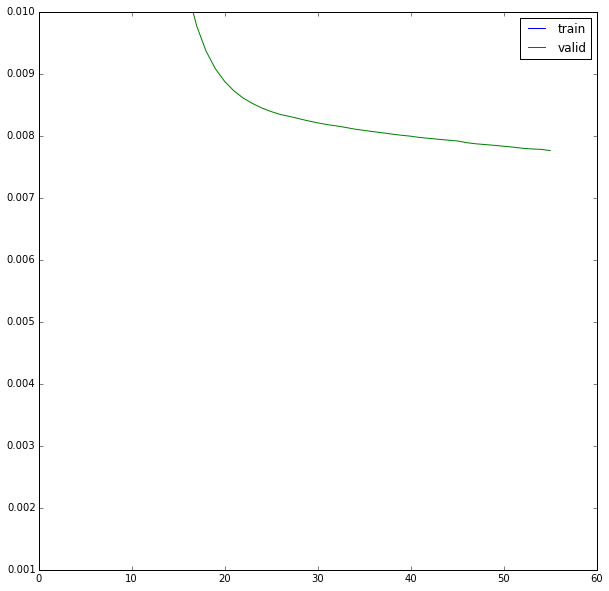

In [30]:
net5_train_errors = np.array([t["train_loss"] for t in net5.train_history_])
net5_valid_errors = np.array([t["valid_loss"] for t in net5.train_history_])
epochs = np.arange(0, net5_train_errors.size)

plt.figure(figsize = (10, 10))
plt.plot(epochs, net5_train_errors, "b-", label = "train")
plt.plot(epochs, net5_valid_errors, "g-", label = "valid")
plt.legend(loc = "best")
plt.ylim((1e-3, 1e-2))

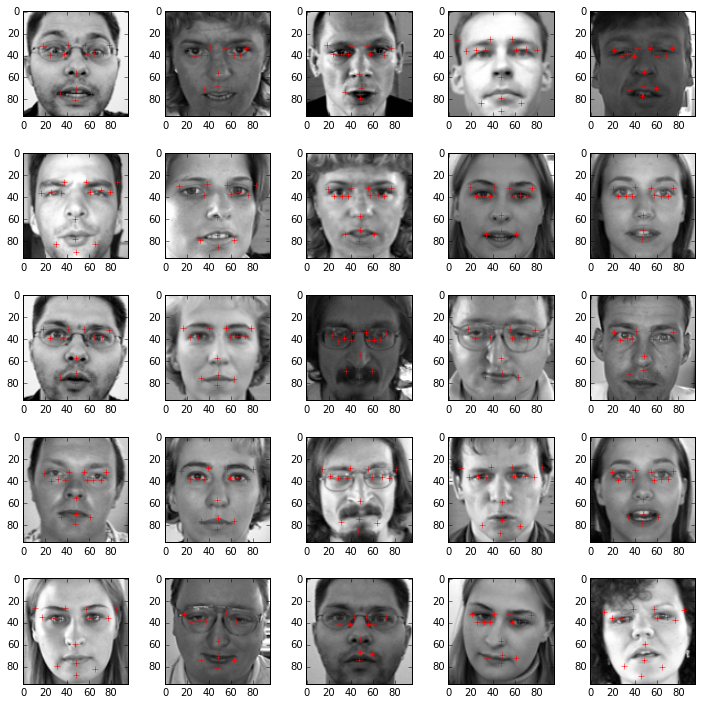

In [31]:
fig, axes = plt.subplots(5, 5, figsize = (10, 10))
fig.tight_layout()
axes = axes.ravel()
        
for i, ax in enumerate(axes):
    img = test_data.iloc[i]["Image"].astype(np.float32)
    features = net5.predict([img.reshape((1, 96, 96))/255])[0] * 48. + 48.
    feature_pts = zip(features[0::2], features[1::2])
    plot_face(img, ax)
    plot_features(feature_pts, ax)